# Siddhartha's CNN Model

## **Acknowledgment**

This notebook contains implementation of the **CNN** approach to **Credit Card Fraud Detection**, based on work by *Siddhartha Pramanik*. The original implementation has been modified and enhanced to better serve the specific requirements of this XAI-focused study project.

- **Run live notebook:** [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ThongLai/Credit-Card-Transaction-Fraud-Detection-Using-Explainable-AI/main?urlpath=%2Fdoc%2Ftree%2FSiddhartha_CNN.ipynb)
- **Original source:** [*Credit_card_Fraud_Detection.ipynb*](https://github.com/siddharthapramanik771/CreditCardFraudDetectionML/blob/main/Credit_card_Fraud_Detection.ipynb)

## Global Setting Variables

In [4]:
LASTEST_MODEL_NAME = 'model_1_Siddhartha_CNN_acc98'
MODEL_PATH = 'architectures/'
DATA_PATH = 'data/'
VISUALIZATION_PATH = 'visualization/'
NEW_MODEL = True
PERFORM_TRAINING = True
SAVE_MODEL = True
RANDOM_SEED = 42 # Set to `None` for the generator uses the current system time.

## Importing the necessary packages

In [2]:
# If you are running on `Binder`, then it is no need to set up the packages again
# %pip install -r requirements.txt

# ---OR---

# %pip install tensorflow==2.10.1 numpy==1.26.4 pandas scikit-learn imblearn matplotlib seaborn requests

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
plt.interactive(True)
sns.set(rc={'figure.figsize':(13.7,8.27)})
# plt.rcdefaults()  # Reset to default plot settings

import sys
import os
import utils

np.random.seed(RANDOM_SEED)

Python Version: `3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]`
Base Python location: `C:\Users\LMT\AppData\Local\Programs\Python\Python310`
Current Environment location: `.venv_xai_fraud_detection`

Tensorflow version: `2.10.1`
CUDNN version: `64_8`
CUDA version: `64_112`
Num GPUs Available: 1


## Getting Relevant Data

### Download dataset

In [4]:
utils.download_dataset_from_kaggle('fraudTrain.csv')
utils.download_dataset_from_kaggle('fraudTest.csv')

URL: https://www.kaggle.com/api/v1/datasets/download/kartik2112/fraud-detection/fraudTrain.csv
File `data/fraudTrain.csv` already exists.
URL: https://www.kaggle.com/api/v1/datasets/download/kartik2112/fraud-detection/fraudTest.csv
File `data/fraudTest.csv` already exists.


### Read data

In [3]:
data_train = pd.read_csv(os.path.join(DATA_PATH, 'fraudTrain.csv'), index_col=0)
data_test = pd.read_csv(os.path.join(DATA_PATH, 'fraudTest.csv'), index_col=0)

## Feature Engineering

In [6]:
data_train['is_fraud'].value_counts()

0    1289169
1       7506
Name: is_fraud, dtype: int64

In [7]:
data_train.isnull().any().sum()

0

no mising data

In [4]:
data_train = utils.feature_engineering(data_train)
data_test = utils.feature_engineering(data_test)

## Feature Description Table

| **Field Name**   | **Description**                                                             |
|------------------|-----------------------------------------------------------------------------|
| **merchant**     | Name of merchant where transaction occurred (e.g., *Starbucks*)             |
| **category**     | Category of merchant (e.g., *retail*, *food*, etc.)                         |
| **amt**          | Amount of transaction (e.g., *$25.50*)                                      |
| **gender**       | Gender of credit card holder (e.g., *Male*, *Female*)                       |
| **lat**          | Latitude location of credit card holder (e.g., *34.0522*)                   |
| **long**         | Longitude location of credit card holder (e.g., *-118.2437*)                |
| **city_pop**     | Population of credit card holder's city (e.g., *4000000*)                   |
| **merch_lat**    | Latitude location of merchant (e.g., *34.0522*)                             |
| **merch_long**   | Longitude location of merchant (e.g., *-118.2437*)                          |
| **age**          | Age of credit card holder (derived from dob, e.g., *28*)                    |
| **age_group**    | Age group category of credit card holder (e.g., *20-29*, *30-39*)           |
| **dist**         | Distance between merchant and card holder locations (e.g., *5.2 miles*)     |
| **hour**         | Hour of day when transaction occurred (e.g., *14*)                          |
| **day_of_week**  | Day of the week when transaction occurred (e.g., *Monday*)                  |
| **month**        | Month when transaction occurred (e.g., *April*)                             |

## Analysis

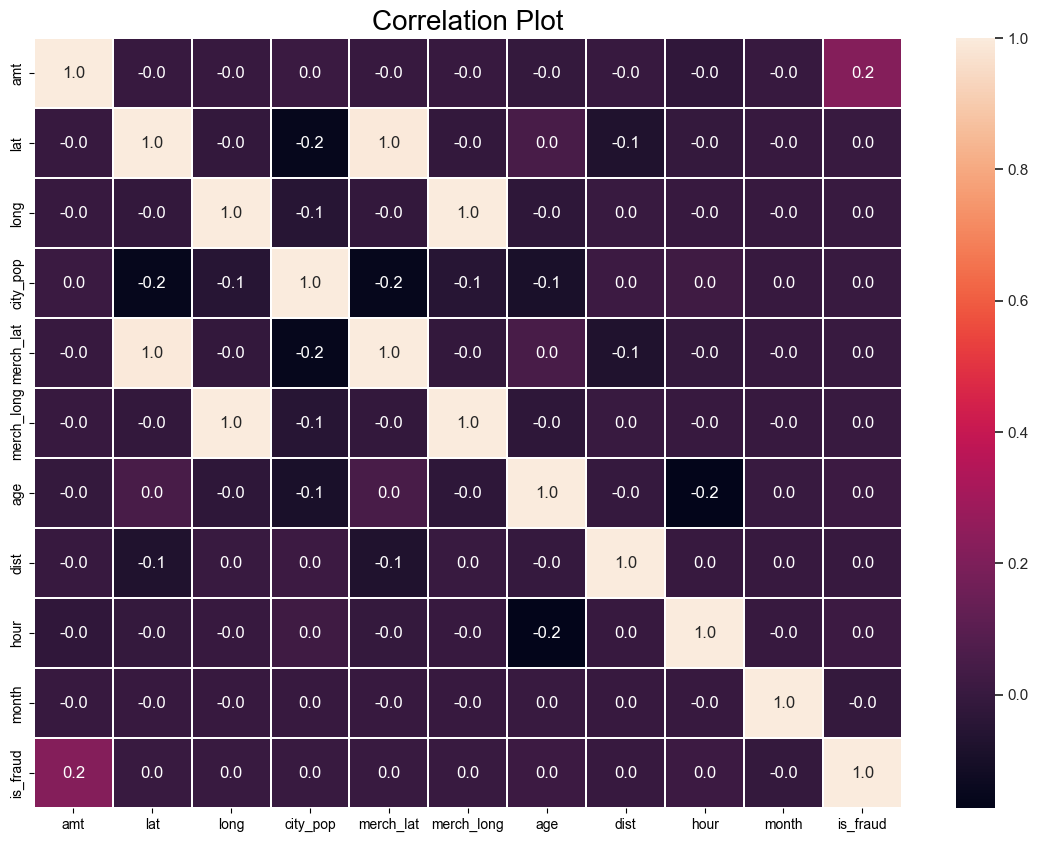

In [9]:
float_types_columns = []
for col in data_train:
    try:
        data_train[col].astype('float')
        float_types_columns.append(col)
    except:
        continue

plt.figure(figsize = (14,10))
plt.title('Correlation Plot', size = 20)
corr = data_train[float_types_columns].corr()
sns.set(rc={'figure.figsize':(13.7,8.27)})
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,fmt='.1f',annot=True)
plt.show()

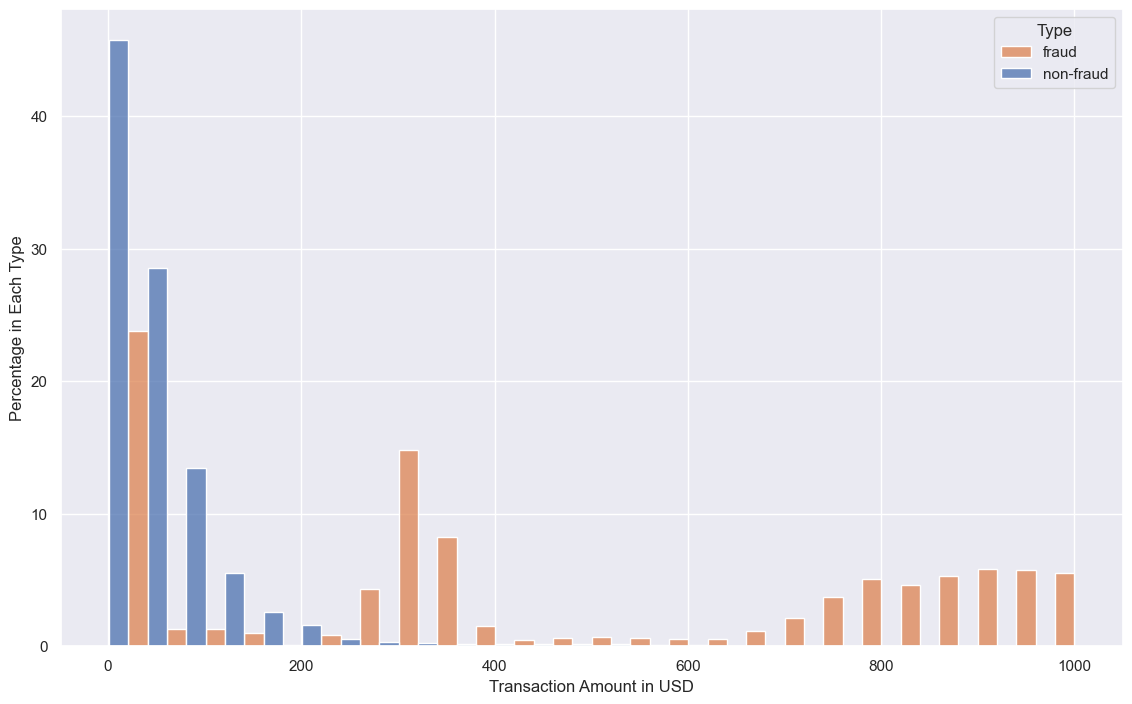

In [10]:
ax=sns.histplot(x='amt',data=data_train[data_train.amt<=1000],hue='is_fraud',stat='percent',multiple='dodge',common_norm=False,bins=25)
ax.set_ylabel('Percentage in Each Type')
ax.set_xlabel('Transaction Amount in USD')
plt.legend(title='Type', labels=['fraud', 'non-fraud'])

In [11]:
# Get all the fraud data
fraud_data = data_train[data_train['is_fraud'] == 1]

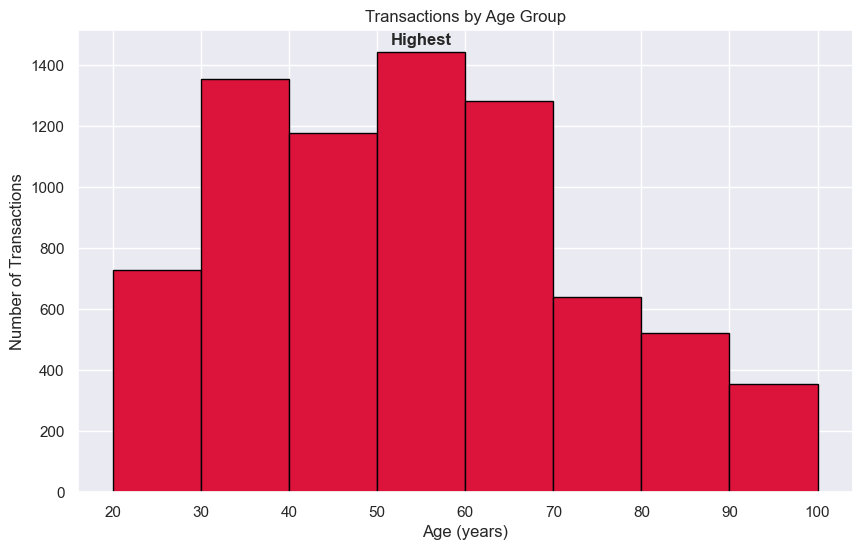

The age group with the most fraud transactions is 50 to 60 with 1443 fraud transactions.


In [12]:
# Define age bins (from 18 to 90 in 10-year increments)
age_bins = range(data_train['age'].min(), data_train['age'].max()+10, 10)

plt.figure(figsize=(10, 6))
plt.xlabel('Age (years)')
plt.ylabel('Number of Transactions')
plt.title('Transactions by Age Group')
plt.xticks(age_bins)

# Create the histogram
counts, bins, patches = plt.hist(fraud_data['age'], bins=age_bins, edgecolor='black', color='crimson')

# Annotate the age group with highest transactions
plt.annotate(f'Highest', 
             xy=(bins[counts.argmax()] + 5, counts.max()),
             xytext=(0, 5),
             textcoords='offset points',
             ha='center',
             fontweight='bold',
)

plt.show()

print(f"The age group with the most fraud transactions is {age_bins[counts.argmax()]} to {age_bins[counts.argmax()+1]} with {int(counts.max())} fraud transactions.")

<Axes: xlabel='gender', ylabel='count'>

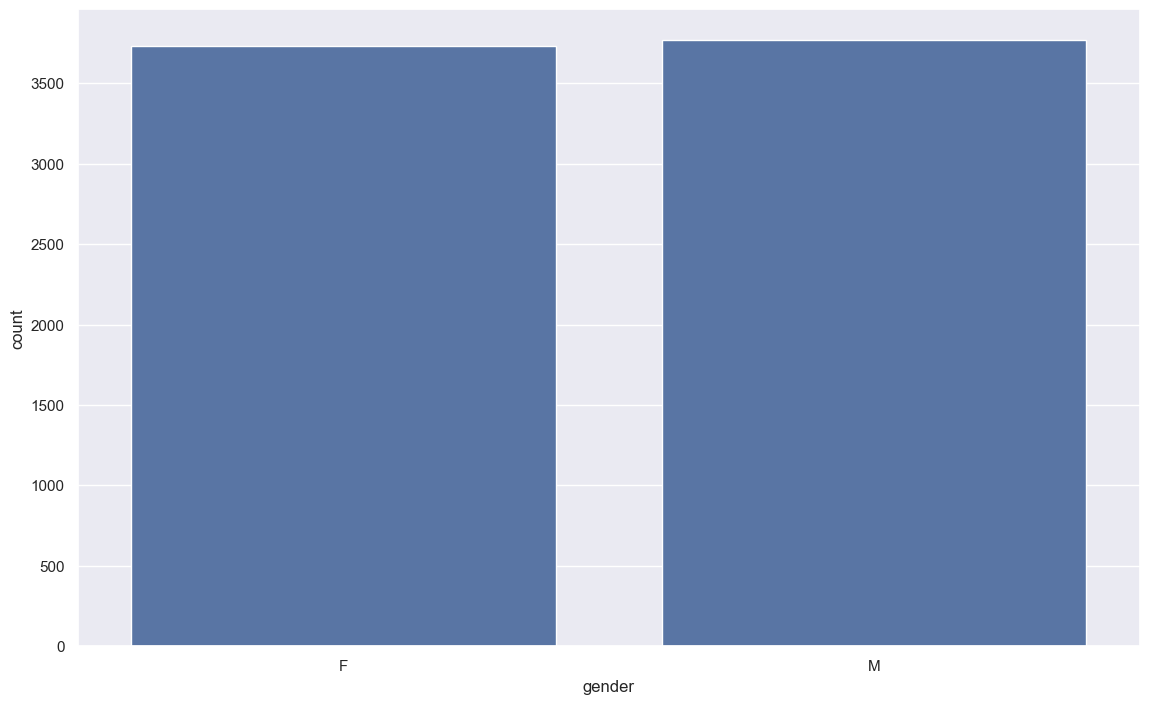

In [13]:
sns.countplot(x="gender", data=fraud_data)

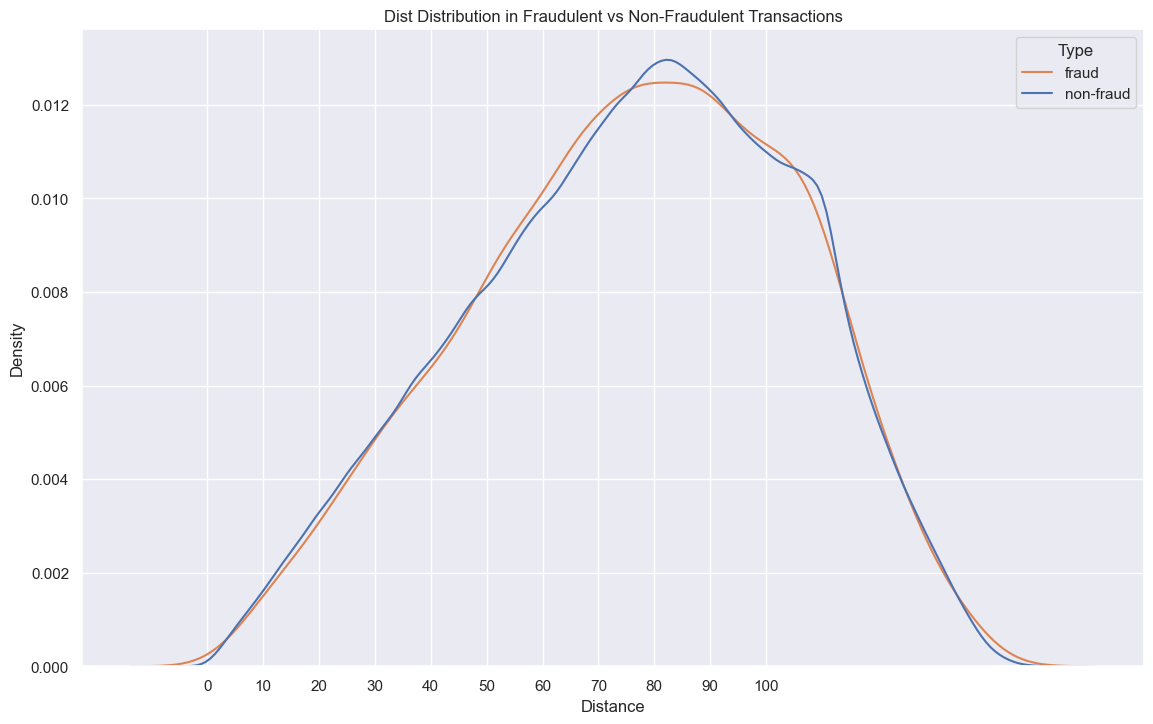

In [14]:
#Relation between distance vs fraud
import datetime as dt
import numpy as np
ax=sns.kdeplot(x='dist',data=data_train, hue='is_fraud', common_norm=False)
ax.set_xlabel('Distance')
ax.set_ylabel('Density')
plt.xticks(np.arange(0,110,10))
plt.title('Dist Distribution in Fraudulent vs Non-Fraudulent Transactions')
plt.legend(title='Type', labels=['fraud', 'non-fraud'])

In [15]:
# sns.countplot(x="state",data=data_train[data_train["is_fraud"]==1])

## Pre-processing

In [5]:
X_train, y_train, data_train, transformations = utils.pre_processing(data_train)

Ordinal-Encoding is applied for `['merchant', 'category', 'gender', 'age_group', 'day_of_week']`
SMOTE is applied


In [6]:
X_test, y_test, data_test, _ = utils.pre_processing(data_test, transformations, isTestSet=True)

Ordinal-Encoding is applied for `['merchant', 'category', 'gender', 'age_group', 'day_of_week']`


In [7]:
X_train.shape

(2578338, 15)

## Model Building

In [19]:
if NEW_MODEL:
    # Define the model
    model = Sequential([
        # First convolutional layer
        Conv1D(
            filters=64,
            kernel_size=2,
            activation='relu',
            input_shape=(X_train.shape[1], 1)
        ),
        BatchNormalization(),
    
        # Second convolutional layer
        Conv1D(
            filters=32,
            kernel_size=2,
            activation='elu'
        ),
        Dropout(0.3),
        
        # Dense layer applied before flattening
        Dense(64, activation='relu'),
        
        # Flatten the output for the fully connected layers
        Flatten(),
        
        # Fully connected hidden layer
        Dense(64, activation='relu'),
        Dropout(0.2),
        
        # Output layer for binary classification
        Dense(1, activation='sigmoid')
    ], name='model_1_Siddhartha_CNN')
else:
    model = utils.load_models(LASTEST_MODEL_NAME) # Continue training previous trained model if needed

In [20]:
model.summary()

Model: "model_1_Siddhartha_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 14, 64)            192       
                                                                 
 batch_normalization (BatchN  (None, 14, 64)           256       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 13, 32)            4128      
                                                                 
 dropout (Dropout)           (None, 13, 32)            0         
                                                                 
 dense (Dense)               (None, 13, 64)            2112      
                                                                 
 flatten (Flatten)           (None, 832)               0         
                                            

## Training

In [21]:
if PERFORM_TRAINING:
    epochs = 50
    batch_size=30000
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics=['accuracy'])
    
    callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=4,
        verbose=1,
        mode='auto',
        baseline=None,
        restore_best_weights=True
    )
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/50
86/86 [==============================] - 19s 184ms/step - loss: 0.3329 - accuracy: 0.8683 - val_loss: 0.5005 - val_accuracy: 0.8448
Epoch 2/50
86/86 [==============================] - 15s 175ms/step - loss: 0.1705 - accuracy: 0.9352 - val_loss: 0.3344 - val_accuracy: 0.9230
Epoch 3/50
86/86 [==============================] - 15s 176ms/step - loss: 0.1308 - accuracy: 0.9505 - val_loss: 0.2709 - val_accuracy: 0.9143
Epoch 4/50
86/86 [==============================] - 15s 177ms/step - loss: 0.1153 - accuracy: 0.9569 - val_loss: 0.2108 - val_accuracy: 0.9258
Epoch 5/50
86/86 [==============================] - 15s 178ms/step - loss: 0.1052 - accuracy: 0.9609 - val_loss: 0.1439 - val_accuracy: 0.9491
Epoch 6/50
86/86 [==============================] - 15s 179ms/step - loss: 0.0970 - accuracy: 0.9641 - val_loss: 0.0922 - val_accuracy: 0.9686
Epoch 7/50
86/86 [==============================] - 15s 178ms/step - loss: 0.0909 - accuracy: 0.9664 - val_loss: 0.0847 - val_accuracy: 0.9713

## Learning Curve

In [3]:
def plot_learningCurve(history, epoch):
    # Plot training & validation accuracy values
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.savefig(os.path.join(VISUALIZATION_PATH, "CNN_accuracy_training_curve.png"), dpi=600, bbox_inches='tight')
    plt.show()
    
    # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.savefig(os.path.join(VISUALIZATION_PATH, "CNN_loss_training_curve.png"), dpi=600, bbox_inches='tight')
    plt.show()

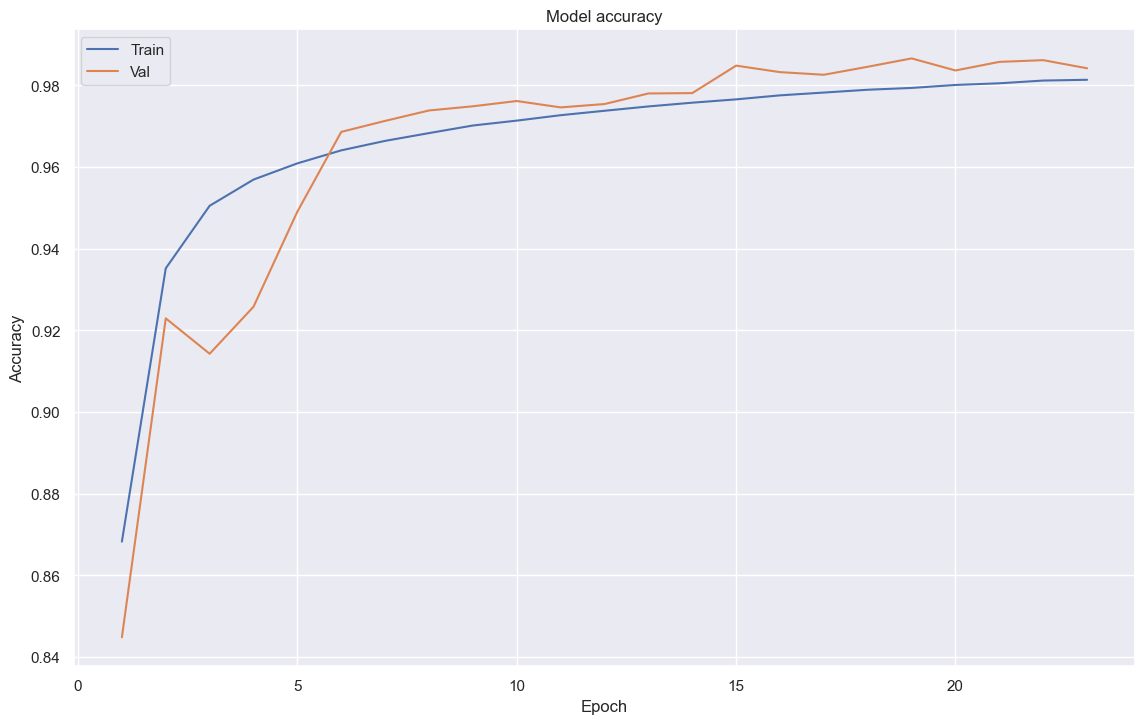

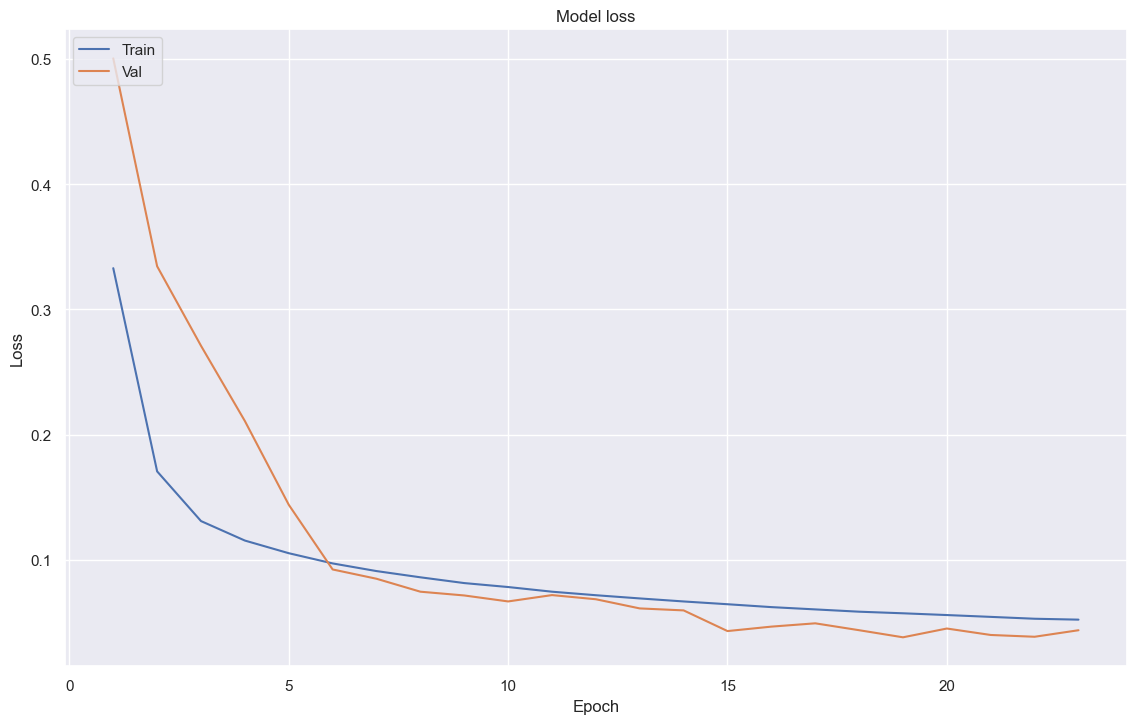

In [23]:
if NEW_MODEL:
    plot_learningCurve(history, len(history.epoch))

## Predictions

In [24]:
y_predict = model.predict(X_test)
y_predict_binary = np.round(y_predict).astype(int).squeeze()

17367/17367 [==============================] - 89s 5ms/step


In [25]:
acc_postfix = f'_acc{accuracy_score(y_test, y_predict_binary)*100:.0f}'

if model.name.find('_acc') != -1:
    model._name = model.name[:model.name.find('_acc')] + acc_postfix
else:
    model._name = model.name + acc_postfix

In [26]:
if SAVE_MODEL:
    # Save predictions
    utils.save_predictions(model.name, y_predict)


[INFO] Saving model `model_1_Siddhartha_CNN_acc99` predictions into `data/predictions.csv`...
[INFO] Loaded `predictions.csv` file.
[INFO] Saved model `model_1_Siddhartha_CNN_acc99` predictions.


In [27]:
classificationReport = classification_report(y_test, y_predict_binary)
print(classificationReport)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    553574
           1       0.21      0.92      0.35      2145

    accuracy                           0.99    555719
   macro avg       0.61      0.95      0.67    555719
weighted avg       1.00      0.99      0.99    555719



In [28]:
confusionMatrix = confusion_matrix(y_test, np.round(y_predict).astype(int))
confusionMatrix

array([[546311,   7263],
       [   175,   1970]], dtype=int64)

## Model Performance Metrics

In [29]:
utils.get_model_metrics_df(y_test, y_predict)

,Metric,Value
0,Accuracy,0.986616
1,ROC AUC Score,0.994009
2,Precision (Class 0),0.999680
3,Recall (Class 0),0.986880
4,F1-Score (Class 0),0.993239
5,Precision (Class 1),0.213365
6,Recall (Class 1),0.918415
7,F1-Score (Class 1),0.346282


## Save model

In [30]:
if SAVE_MODEL:
    model.save(os.path.join(MODEL_PATH, model.name))
    # model.save(os.path.join(MODEL_PATH, model.name}.h5'))

INFO:tensorflow:Assets written to: architectures/model_1_Siddhartha_CNN_acc99\assets


INFO:tensorflow:Assets written to: architectures/model_1_Siddhartha_CNN_acc99\assets
